<a href="https://colab.research.google.com/github/elizamirzoyan/time-series-clustering/blob/main/Time_Series_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import cdist_dtw
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA

In [14]:
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
y_train = y_train - 1
y_test = y_test - 1
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [15]:
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Unique class labels:", np.unique(y))

Train data shape: (100, 275, 1)
Test data shape: (100, 275, 1)
Unique class labels: [0 1 2 3]


In [16]:
scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


K-means

In [21]:
km = TimeSeriesKMeans(n_clusters=4,
                     metric="euclidean",
                     max_iter=50,
                     random_state=0)
km_labels = km.fit_predict(X_scaled)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Hierarchical Clustering

In [22]:
dtw_distances = cdist_dtw(X_scaled,
                         global_constraint="sakoe_chiba",
                         sakoe_chiba_radius=3)
hc = AgglomerativeClustering(n_clusters=4,
                            metric="precomputed",
                            linkage="average")
hc_labels = hc.fit_predict(dtw_distances)

In [26]:
ari_km = adjusted_rand_score(y, km_labels)
nmi_km = normalized_mutual_info_score(y, km_labels, average_method='arithmetic')
ari_hc = adjusted_rand_score(y, hc_labels)
nmi_hc = normalized_mutual_info_score(y, hc_labels, average_method='arithmetic')

In [28]:
print("\n" + "="*50)
print("Clustering Performance Comparison")
print("="*50)
print(f"{'Metric':<25} {'K-means':<15} {'Hierarchical (DTW)':<15}")
print(f"{'Adjusted Rand Index':<25} {ari_km:.3f}{'':<10} {ari_hc:.3f}")
print(f"{'Normalized Mutual Info':<25} {nmi_km:.3f}{'':<10} {nmi_hc:.3f}")


Clustering Performance Comparison
Metric                    K-means         Hierarchical (DTW)
Adjusted Rand Index       0.327           0.411
Normalized Mutual Info    0.502           0.548


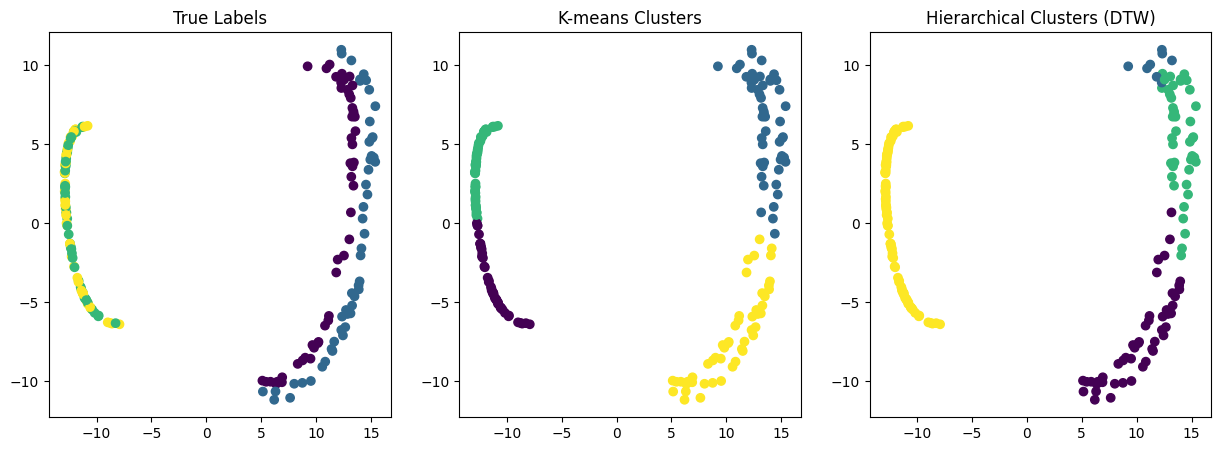

In [29]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled.reshape(X_scaled.shape[0], -1))

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.title("True Labels")

plt.subplot(132)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km_labels, cmap='viridis')
plt.title("K-means Clusters")

plt.subplot(133)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hc_labels, cmap='viridis')
plt.title("Hierarchical Clusters (DTW)")
plt.show()

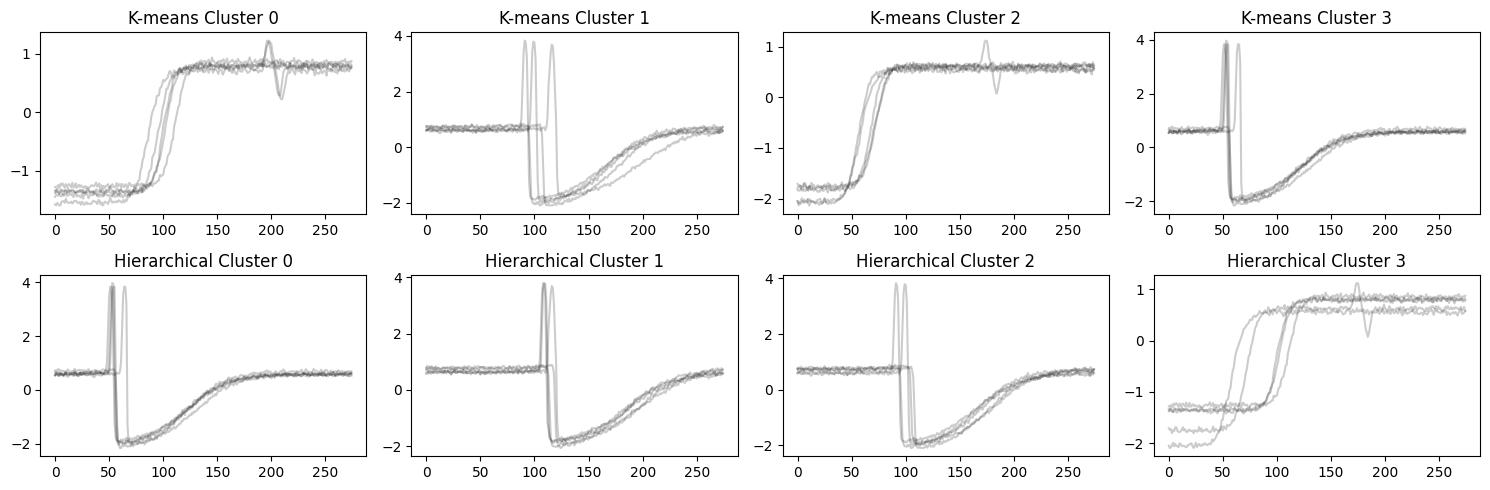

In [30]:
plt.figure(figsize=(15, 5))
for cluster_id in range(n_clusters):
    plt.subplot(2, n_clusters, cluster_id + 1)
    for ts in X_scaled[km_labels == cluster_id][:5]:
        plt.plot(ts.ravel(), "k-", alpha=0.2)
    plt.title(f"K-means Cluster {cluster_id}")

    plt.subplot(2, n_clusters, cluster_id + 1 + n_clusters)
    for ts in X_scaled[hc_labels == cluster_id][:5]:
        plt.plot(ts.ravel(), "k-", alpha=0.2)
    plt.title(f"Hierarchical Cluster {cluster_id}")
plt.tight_layout()
plt.show()